In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import numba as nb
from IPython.display import Markdown, display,HTML,Image
from z3 import *

### Puzzle as published 
https://www.janestreet.com/puzzles/current-puzzle/

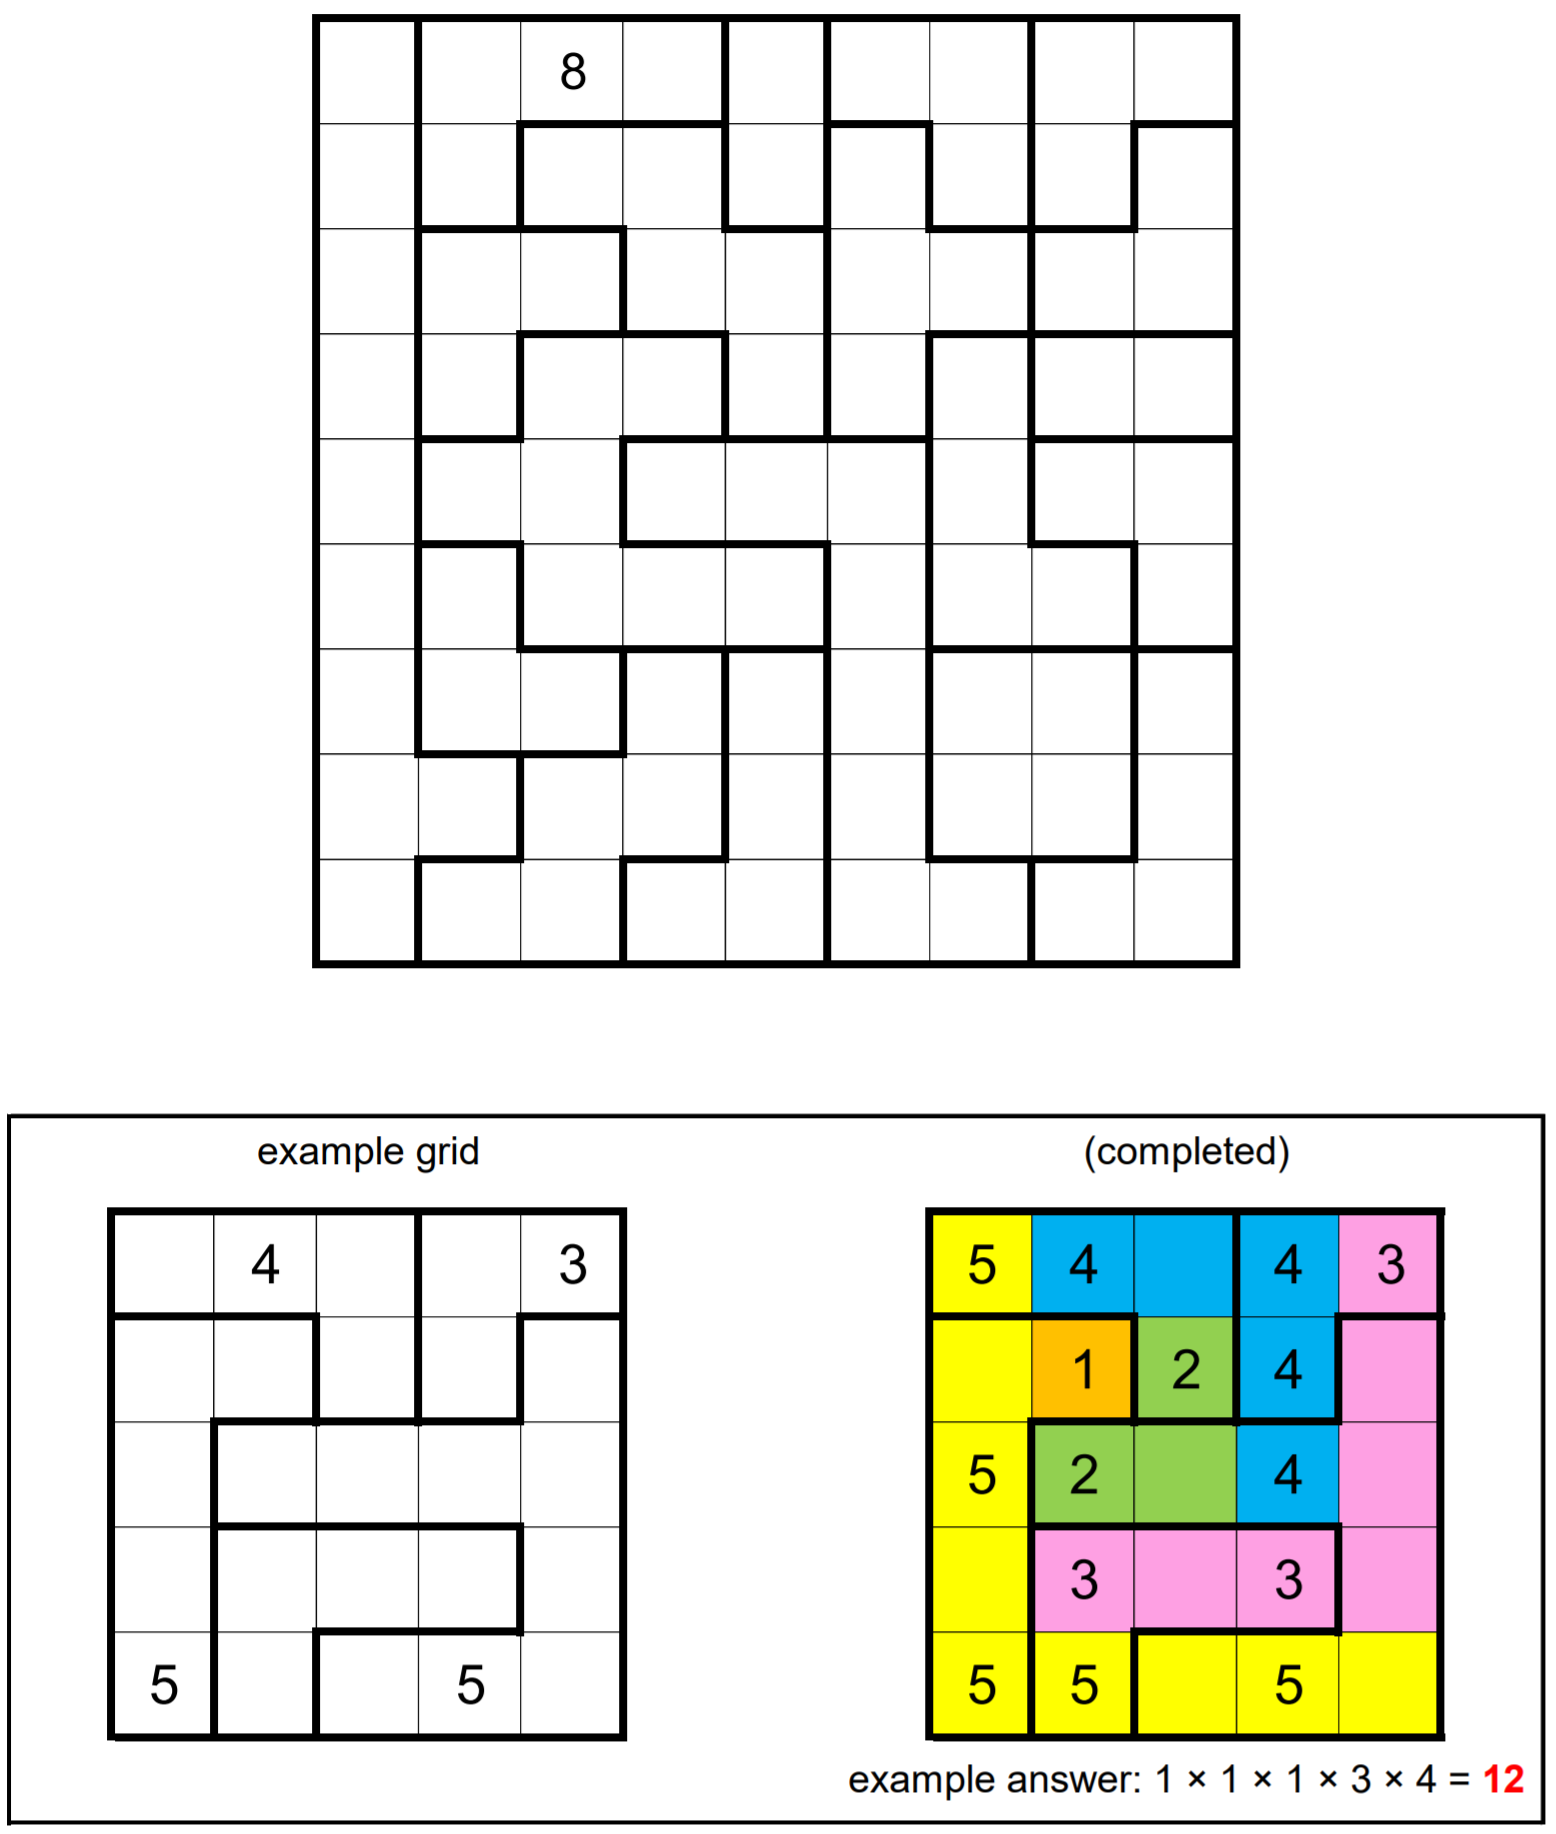

In [2]:
# Hooks again but the change is the nxn hook does not have to contain n's.
# Also shows up a issue in my connectivitity calcs when looking for valid grids,which excluded the right answer. Now 
# it's only checked at the end but makes it a lot slower. Used z3 to speed up the final placements (~20 times faster than
# numba enhanced backtracking !!) so got the speed down.  

url='https://www.janestreet.com/puzzles/current-puzzle/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/2022-01-01-hooks-8.png',width=200))
HTML(str(soup.find('div', {'class' :'inner-wrapper'})).replace('<p><img src=\"/puzzles/2022-01-01-hooks-8.png\"/></p>',''))


In [3]:
# Setup the constraints
# use 20 for the filled cells and treat as smaller 
# group with a different total


groups = np.array([[ 1, 0,20, 0, 2, 3, 3, 4, 4],
                   [ 1, 0, 5, 5, 2,14, 3, 4, 7],
                   [ 1, 8, 8, 5, 5,14,14, 7, 7],
                   [ 1, 8, 9, 9, 5,14,10,11,11],
                   [ 1, 9, 9,12,12,12,10,13,13],
                   [ 1, 6, 9, 9, 9,12,10,10,13],
                   [ 1, 6, 6,15,16,12,17,17,18],
                   [ 1, 1,15,15,16,12,17,17,18],
                   [ 1,15,15,16,16,12,12,18,18]])

In [9]:
class Matrix():
    def __init__(self,groups):
        self.groups = groups
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9],[*range(1,10)]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled,nums not usrd]
        self.solution = []
        self.totals =np.ones(19,dtype=int)*sum([i**2 for i in range(10)])/19
        self.totals[0] -=8
        self.splits ={}
        self.end_flag = 0
        self.start =0
        # work out the possible permutations for each group
        for i in range(19):
            length = np.sum(groups==i)
            self.splits[i] =  np.array([list(i) for i in itertools.product([0, 1], repeat=length)],dtype=int)
     
    #########################################################
    # Code to get the initial valid grids 
    # add layer by layer until it is not possible to create the sum 
    # for every filled group

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        if alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        if alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        if alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords
    
    def check_grid(self,grid):
        # check the fixed number
        if (grid[0,2] !=-1) & (grid[0,2] !=8):
            return False
        
        # make sure there is enough space in the grid for all the numbers needed
        if not(self.count(grid)):
            return False     
        
        #check if possible to make 15 in the group.
        for i in range(19):
            group = grid[groups==i]
            if -1 not in group:
                if not self.check_group(group,self.totals[i],self.splits[i]):
                    return False
        return True
    
    @staticmethod
    @nb.njit(fastmath=True)
    def check_group(group,param,splits):
        for split in splits:
            test = group * split
            if np.sum(test) == param:
                return True
        return False
    
    @staticmethod
    @nb.njit(fastmath=True)
    def valid_group(pos,param):
        if np.sum(pos) !=param:
                return False
        return True
    
    @staticmethod
    @nb.njit(fastmath=True)
    def count(grid):
        for num in range(2,10):
            if np.any(grid==num) and (np.sum(grid == num) < num):
                   return False
            if np.any(grid==1) and (np.sum(grid ==1) !=1):
                   return False
        return True
    
    #########################################################
    # Code to get the cells forced by the group params
    # loop through all the splits for each group saving the valid ones
    # for the digits common to all the valid splits set as forced
    # done the fixed cell manually
    def forced_cells(self,hook):
        forced = np.ones((9,9),dtype=int)*-1
        forced[0,2] = 1
        
        # loop through the params to determine forced cells
        for i in range(19):
            forced[self.groups==i] = self.forced_group(hook[self.groups==i],self.totals[i],self.splits[i])
              
        # Set the cell with 1 in as 1. Then loop through and fill in cells.
        forced[hook==1] =1
        test =forced*hook
        
        # check that the forced cells do not violate the count
        for i in range(1,10):
            if np.sum(test==i) > i:
                return 0,forced
            
        # check that the forced cells do not violate 2x2
        if self.twobytwo(test):
            return 0,forced
        
        return  1,forced
      
    def forced_group(self,group,param,splits):
        # loop through every split.Save the valid ones an then determine 
        # if any entries are common to all valid splits
        poss_group =[]
        length = len(splits[0])
        for split in splits:
            test = group * split
            if self.valid_group(test,param):
                    poss_group.append(split)
        poss_array = np.array(poss_group)
        forced = np.ones(length,dtype=int)*-1
        for i in range(length):
            if np.all(poss_array[:,i]==1):
                forced[i] =1
            elif np.all(poss_array[:,i]==0):
                forced[i] =0
        return forced
    
    @staticmethod
    @nb.njit(fastmath=True)
    def twobytwo(grid):
        #check the 2x2 condition
        for i in range(9):
            for j in range(9):
                if (i > 0 and j > 0 and 
                    grid[i,j] > 0 and
                    grid[i-1,j-1] > 0 and 
                    grid[i-1,j] > 0 and 
                    grid[i,j-1] > 0):
                        return True
    
                if (i > 0 and j < 7 and
                    grid[i,j] > 0 and
                    grid[i-1,j+1] > 0 and 
                    grid[i-1,j] > 0 and 
                    grid[i,j+1] > 0):
                        return True
    
                if (i < 7 and j > 0 and
                    grid[i,j] > 0 and
                    grid[i+1,j-1] > 0 and 
                    grid[i+1,j] > 0 and 
                    grid[i,j-1] > 0):
                        return True

    
                if (i < 7 and j < 7 and
                    grid[i,j] > 0 and
                    grid[i+1,j+1] > 0 and 
                    grid[i+1,j] > 0 and 
                    grid[i,j+1] > 0):
                        return True
    
        return False
    
    ########################################################
    # Fill the final cells using z3    
    def neighbours(self,i, j):
        l=[]
        if i-1 >= 0:
            l.append((i-1,j))
        if i+1 < 9:
            l.append((i+1,j))
        if j-1 >= 0:
            l.append((i,j-1))
        if j+1 < 9:
            l.append((i,j+1))
        return l
    
    def fill_rest(self,grid,hooks):  
        #set up solver and variables
        s = Tactic("pqffd").solver()
        N =9
        X = np.array(IntVector('x', N*N),dtype=object).reshape((N,N))
        
        # force fixed and set to either 0/1
        s += [e == int(grid[i,j]) for (i,j),e in np.ndenumerate(X) if grid[i,j]!=-1]
        s += [And(e >= 0  ,e <= 1) for (i,j),e in np.ndenumerate(X)]
        
        #groups ==15
        groups_adj= np.array(groups)
        s += And([sum([hooks[i,j]*e for (i,j),e in np.ndenumerate(X) if groups_adj[i,j] == g]) == self.totals[g] for g in range(19)])
        
        # no 2x2
        s += [Or(e ==0,X[i+1][j] ==0,X[i][j+1] ==0,X[i+1][j+1] ==0) for (i,j),e in np.ndenumerate(X[:-1,:-1])]
        
        #cells have at least one neighbour to help connectivity
        s += [Implies(e !=0,Or([X[k,l] !=0 for (k,l) in self.neighbours(i,j)])) for (i,j),e in np.ndenumerate(X)]
        
        # count of numbers in hook
        s += And([sum([e for (i,j),e in np.ndenumerate(X) if int(hooks[i,j])==h]) == h for h in range(1,10)])
        
        # function to evaluate
        evalu = np.vectorize(lambda x :m.evaluate(x).as_long())
        if s.check() == sat:
            m = s.model()
            result = evalu(X)
            # loop through answers until meets connectivity constraint
            while np.max(label(result != 0,connectivity=1))> 1 :
                s += Or([e != int(result[i,j]) for (i,j),e in np.ndenumerate(X)])
                if s.check() == sat:
                    m = s.model()
                    result = evalu(X)
                else:
                    return
            grid =result
            sol_print(grid,hooks,self.groups)
            print("\nThe product of the areas is : {:,.0f}".format(self.areas(grid)))
            print('\nTook {:.4f} seconds'.format((time.time()-self.start)))
            self.end_flag = 1         
            
    ##############################################
    # Get the products of the areas of the connected cells
    def areas(self,grid):
        labels, num = measurements.label(grid==0)
        areas = measurements.sum(grid==0, labels, index=range(1, num+1))
        return np.prod(areas)

    ###############################################
    # Main solver.    
    def solve(self): 
        self.start = time.time()
        while len(self.potential_grids) > 0:
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
            l,g,c,nums = temp_grid
            for num in nums:   
                for alignment in range(3,-1,-1):
                    lvl= dcopy(l)
                    grid= dcopy(g)
                    coords=dcopy(c)
                    grid,coords = self.add_layer(grid,coords,num,alignment)
                    if lvl != -1 :
                        rotations.append([lvl+1,grid,coords,[n for n in nums if n != num]])
                    else:
                        rotations = [[lvl+1,grid,coords,[n for n in nums if n != num]]]
                        
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords,nums = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords,nums])
                    else:
                        self.solution.append(g)                     
                    
        print("Found {} valid hook placements in {:.4f} seconds\n".format(len(self.solution),time.time()-self.start))
            
        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            hooks = self.solution[i]
            if self.end_flag == 0:
                flag,forced_grid = self.forced_cells(hooks)
                # if still valid after forced cells then solve using z3
                if flag:
                    print("Checking grid {} after {:.4f} seconds".format(i,time.time()-self.start),end="\t")
                    self.fill_rest(forced_grid,hooks)
                    if self.end_flag == 0:
                        print(" ... invalid after {:.4f} seconds".format(time.time()-self.start))
                        pass
            else:
                break
                
# Code to print the answer                           
def sol_print(solved,matrix,groups):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] =""
    groups_fixed = dcopy(groups)
    groups_fixed[0,2] = 0
    ax1 =sns.heatmap(matrix,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=2,ax=ax[0],linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax2 =sns.heatmap(groups_fixed,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=2,ax=ax[1],linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax1.axis("off")
    ax2.axis("off")
    plt.tight_layout()
    plt.show()

Found 839 valid hook placements in 1.9968 seconds

Checking grid 86 after 2.2352 seconds	 ... invalid after 2.3509 seconds
Checking grid 129 after 2.4706 seconds	 ... invalid after 2.5852 seconds
Checking grid 140 after 2.6151 seconds	 ... invalid after 2.7339 seconds
Checking grid 193 after 2.8795 seconds	 ... invalid after 3.0041 seconds
Checking grid 194 after 3.0081 seconds	

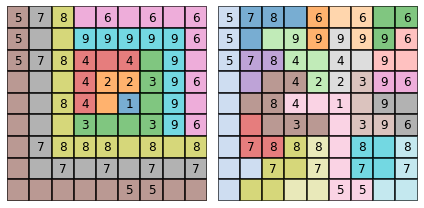


The product of the areas is : 680

Took 12.5486 seconds


In [11]:
test = Matrix(groups)
test.solve()

### Solution as published 
https://www.janestreet.com/puzzles/hooks-8-solution/

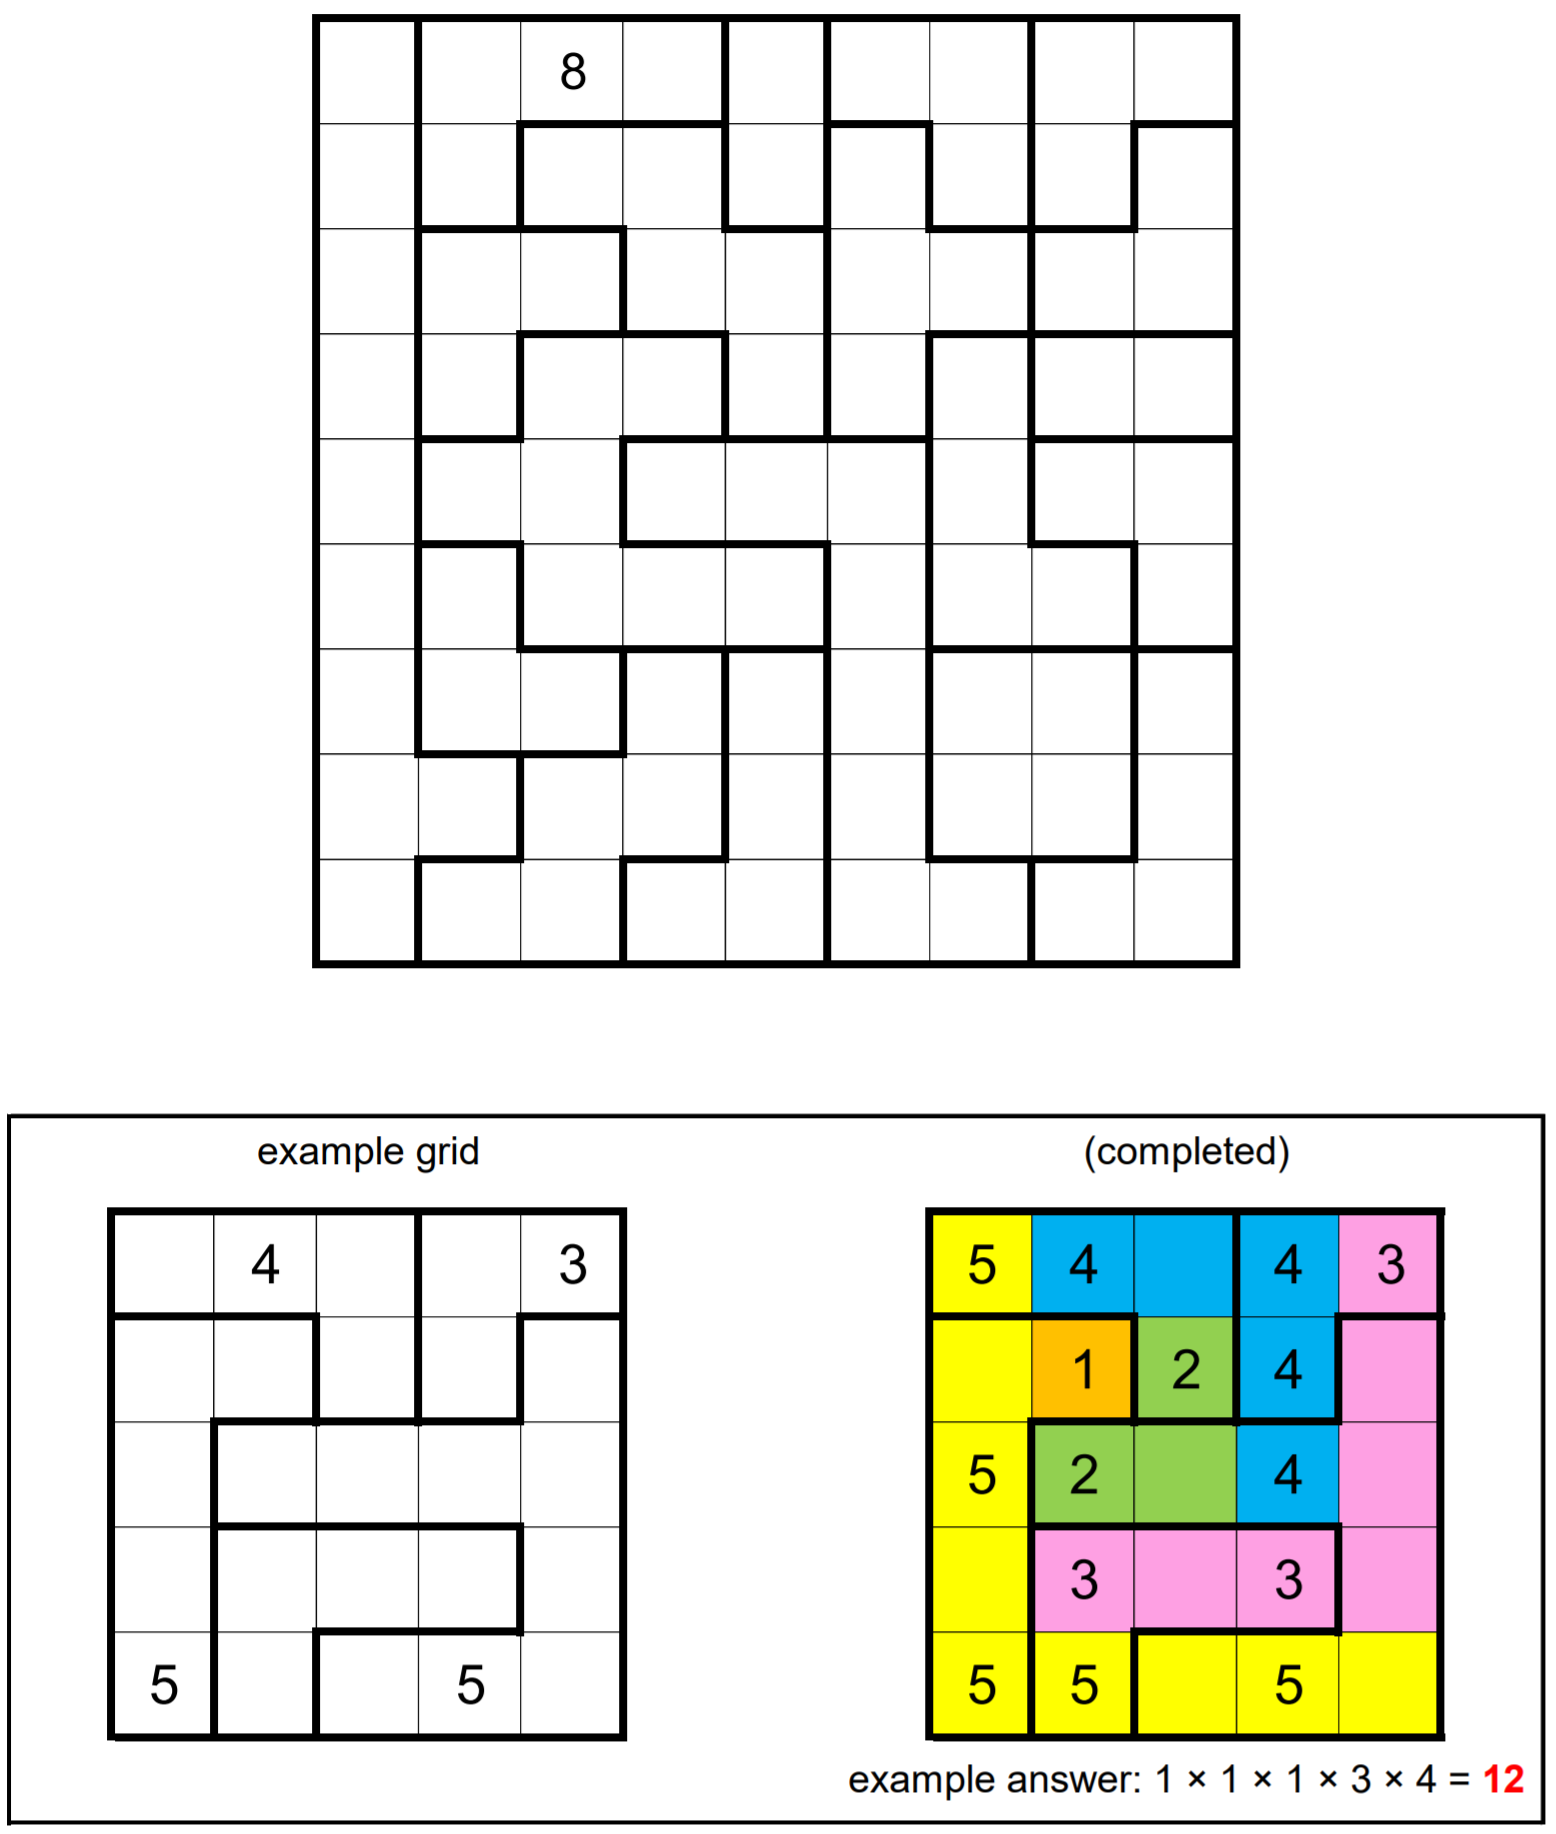

In [6]:
url='https://www.janestreet.com/puzzles/hooks-8-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/2022-01-01-hooks-8.png',width=300))
HTML(str(soup.find('div', {'class' :'inner-wrapper'})))

In [7]:
grid  = np.array([[1, 1, 1, 0, 1, 0, 1, 0, 1],
                  [1, 0, 0, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 0, 1, 0, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 1, 1],
                  [0, 0, 1, 1, 0, 1, 0, 1, 0],
                  [0, 0, 0, 1, 0, 0, 1, 1, 1],
                  [0, 1, 1, 1, 1, 0, 1, 0, 1],
                  [0, 0, 1, 0, 1, 0, 1, 0, 1],
                  [0, 0, 0, 0, 0, 1, 1, 0, 0]])

hooks = np.array([[5, 7, 8, 6, 6, 6, 6, 6, 6],
                  [5, 7, 8, 9, 9, 9, 9, 9, 6],
                  [5, 7, 8, 4, 4, 4, 3, 9, 6],
                  [5, 7, 8, 4, 2, 2, 3, 9, 6],
                  [5, 7, 8, 4, 2, 1, 3, 9, 6],
                  [5, 7, 8, 3, 3, 3, 3, 9, 6],
                  [5, 7, 8, 8, 8, 8, 8, 8, 8],
                  [5, 7, 7, 7, 7, 7, 7, 7, 7],
                  [5, 5, 5, 5, 5, 5, 5, 5, 5]])